# Sentiment Analysis: Twitter vs Amazon Review Data

This notebook compares different sentiment analysis models on Twitter and Amazon datasets.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Data Loading

In [2]:
amazon_data = pd.read_csv('amazon_reviews.csv')
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [3]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [4]:
amazon_data.duplicated().sum()

np.int64(0)

In [5]:
amazon_data.isnull().sum()

,0
Unnamed: 0,0
reviewerName,1
overall,0
reviewText,1
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


In [6]:
amazon_data.dropna(subset=['reviewerName', 'reviewText'], inplace=True)

amazon_data.drop_duplicates(subset=['reviewText'], keep='first', inplace=True)
amazon_data.reset_index(drop=True, inplace=True)

display(amazon_data.head())
print(amazon_data.shape)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


(4912, 12)


In [7]:
def categorize_sentiment(row):
    if row['overall'] > 3:
        return 'positive'
    elif row['overall'] < 3:
        return 'negative'
    else:
        # Check if the review text contains any sentiment words
        text = row['reviewText'].lower()
        positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'like', 'recommend', 'awesome', 'best',
                          'wonderful', 'well', 'perfect', 'happy', 'satisfied', 'ideal', 'superb', 'fantastic', 'outstanding']
        negative_words = ['bad', 'poor', 'terrible', 'awful', 'hate', 'dislike', 'disappoint', 'disappointed',
                          'regret', 'unhappy', 'problem', 'issue', 'mistake', 'waste', 'wasted', 'return', 'refund']
        irrelevant_words = ['ok', 'okay', 'fine', 'average', 'alright', 'satisfactory', 'neutral',
                            'no opinion', 'no feelings', 'no sentiment', 'no emotion', 'no attitude']

        if any(word in text for word in positive_words):
            return 'positive'
        elif any(word in text for word in negative_words):
            return 'negative'
        else:
            return 'irrelevant'

# Apply the function to create the 'type' column
amazon_data['type'] = amazon_data.apply(categorize_sentiment, axis=1)

# Display the first few rows to verify the new column
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [8]:
from copy import deepcopy
df = deepcopy(amazon_data)
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [9]:
df['type'].value_counts()

,count
type,
positive,4523
negative,353
irrelevant,36


In [10]:
df.isnull().sum()

,0
Unnamed: 0,0
reviewerName,0
overall,0
reviewText,0
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


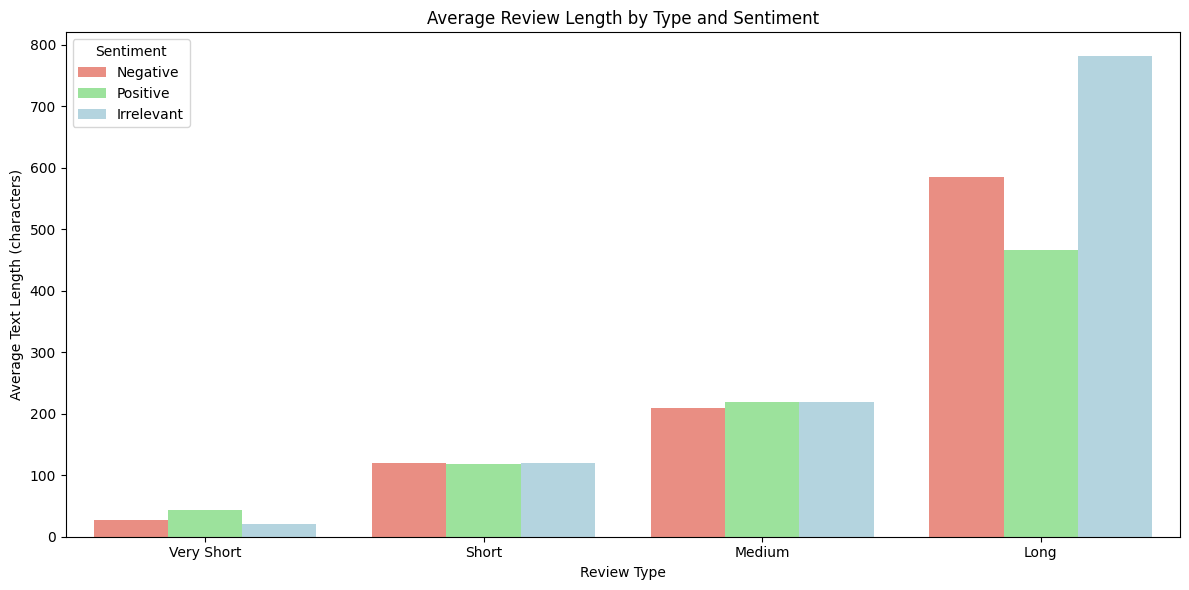

In [11]:
# Calculate text length for each review
df['text_length'] = df['reviewText'].apply(len)

# Define bins and labels for review length
bins = [0, 50, 150, 300, np.inf]
labels = ['Very Short', 'Short', 'Medium', 'Long']
df['review_type'] = pd.cut(df['text_length'], bins=bins, labels=labels)

# Ensure sentiment column exists
if 'sentiment' not in df.columns:
    df['sentiment'] = (df['overall'] > 3).astype(int)

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='review_type', y='text_length', hue='type',
           data=df, palette=['salmon', 'lightgreen', 'lightblue'],
           ci=None)  # No confidence intervals

plt.title('Average Review Length by Type and Sentiment')
plt.xlabel('Review Type')
plt.ylabel('Average Text Length (characters)')
plt.legend(title='Sentiment', labels=['Negative', 'Positive', 'Irrelevant'])
plt.tight_layout()
plt.show()

In [13]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Fill NaNs with empty string
df['reviewText'] = df['reviewText'].fillna('')

df['lower'] = df['reviewText'].str.lower()
df['lower'] = df['lower'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['lower'] = df['lower'].apply(lambda x: re.sub(r'\d+', '', x))
df['lower'] = [str(i).strip() for i in df['lower']]

# Define function to remove punctuation, numbers, stopwords, then tokenize, stem, and lemmatize in lower column
def preprocess_text(text):
    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in (stop_words)])

    # Tokenization
    text = word_tokenize(text)

    # Stemming
    stemmer = nltk.PorterStemmer()
    text = [stemmer.stem(y) for y in text]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(y) for y in text]

    return text

df['lower'] = df['lower'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type,text_length,review_type,sentiment,lower
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive,158,Medium,1,"[purchas, devic, work, advertis, never, much, ..."
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive,166,Medium,1,"[work, expect, sprung, higher, capac, think, m..."
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive,340,Long,1,"[think, work, greathad, diff, bran, gb, card, ..."
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive,290,Medium,1,"[bought, retail, packag, arriv, legit, orang, ..."
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive,282,Medium,1,"[mini, storag, doesnt, anyth, el, suppos, purc..."


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Perform Word Embedding using CountVectorizer
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y, shuffle=True)

# Define a function to train and evaluate the model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    return accuracy, precision, recall, f1, auc_roc

# Initialize Linear Regression model
lr = LogisticRegression()

# Train and evaluate the model
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc_roc = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Logistic Regression Model')
print('-------------------------')
print('Accuracy:', lr_accuracy)
print('Precision:', lr_precision)
print('Recall:', lr_recall)
print('F1 Score:', lr_f1)
print('AUC-ROC:', lr_auc_roc)

Logistic Regression Model
-------------------------
Accuracy: 0.9379450661241099
Precision: 0.9510337323177367
Recall: 0.9820224719101124
F1 Score: 0.9662797125483693
AUC-ROC: 0.7490757520840885


---------------------- Confusion Matrix for Logistic Regression Model ----------------------


<Figure size 800x600 with 0 Axes>

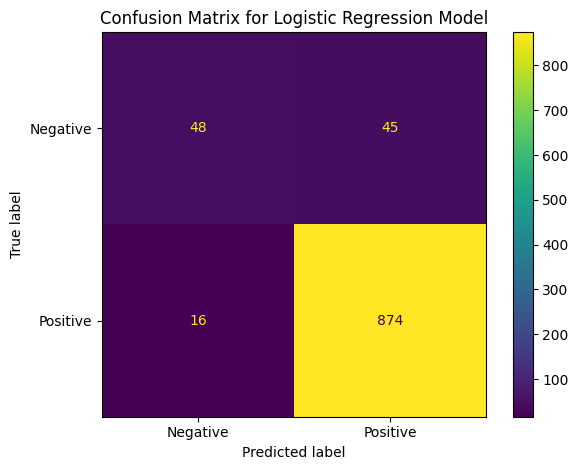

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, lr.predict(X_test))
print('---------------------- Confusion Matrix for Logistic Regression Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

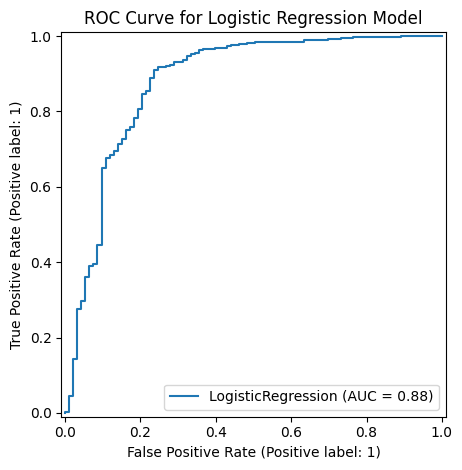

In [16]:
# Plot the ROC curve
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr, X_test, y_test)

plt.title('ROC Curve for Logistic Regression Model')
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import classification_report

# Generate classification report for Logistic Regression model
print('---------------------- Classification Report of Logistic Regression Model ----------------------')
print(classification_report(y_test, lr.predict(X_test), target_names=['Negative', 'Positive']))

---------------------- Classification Report of Logistic Regression Model ----------------------
              precision    recall  f1-score   support

    Negative       0.75      0.52      0.61        93
    Positive       0.95      0.98      0.97       890

    accuracy                           0.94       983
   macro avg       0.85      0.75      0.79       983
weighted avg       0.93      0.94      0.93       983



In [18]:
# Initialize Multinomial Naive Bayes model
nb = MultinomialNB()

# Train and evaluate the model
nb_accuracy, nb_precision, nb_recall, nb_f1, nb_auc_roc = train_evaluate_model(nb, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Multinomial Naive Bayes Model')
print('-----------------------------')
print('Accuracy:', nb_accuracy)
print('Precision:', nb_precision)
print('Recall:', nb_recall)
print('F1 Score:', nb_f1)
print('AUC-ROC:', nb_auc_roc)

Multinomial Naive Bayes Model
-----------------------------
Accuracy: 0.9348931841302136
Precision: 0.9588888888888889
Recall: 0.9696629213483146
F1 Score: 0.964245810055866
AUC-ROC: 0.7859067294913615


---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------


<Figure size 800x600 with 0 Axes>

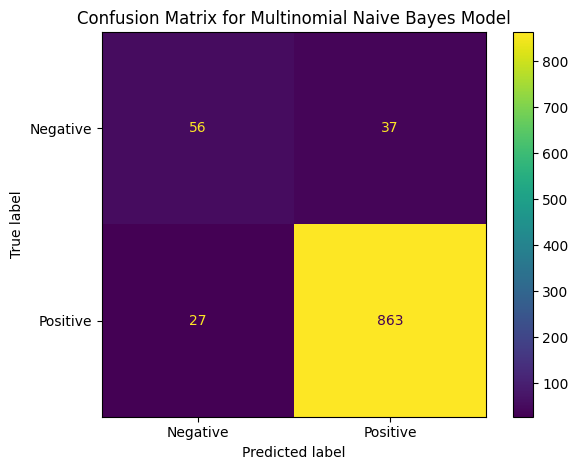

In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, nb.predict(X_test))
print('---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

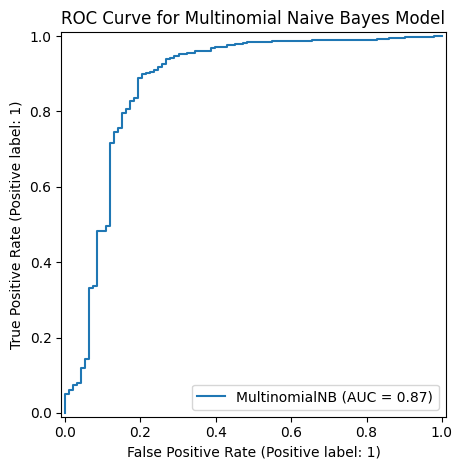

In [20]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(nb, X_test, y_test)

plt.title('ROC Curve for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.show()

In [21]:
# Classification report for Multinomial Naive Bayes model
print('---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------')
print(classification_report(y_test, nb.predict(X_test), target_names=['Negative', 'Positive']))

---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------
              precision    recall  f1-score   support

    Negative       0.67      0.60      0.64        93
    Positive       0.96      0.97      0.96       890

    accuracy                           0.93       983
   macro avg       0.82      0.79      0.80       983
weighted avg       0.93      0.93      0.93       983



In [22]:
# Initialize Random Forest Classifier model
rf = RandomForestClassifier()

# Train and evaluate the model
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc_roc = train_evaluate_model(rf, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Random Forest Classifier Model')
print('-----------------------------')
print('Accuracy:', rf_accuracy)
print('Precision:', rf_precision)
print('Recall:', rf_recall)
print('F1 Score:', rf_f1)
print('AUC-ROC:', rf_auc_roc)

Random Forest Classifier Model
-----------------------------
Accuracy: 0.9114954221770092
Precision: 0.9143446852425181
Recall: 0.9955056179775281
F1 Score: 0.9532006455083378
AUC-ROC: 0.5515162498489792


---------------------- Confusion Matrix for Random Forest Classifier Model ----------------------


<Figure size 800x600 with 0 Axes>

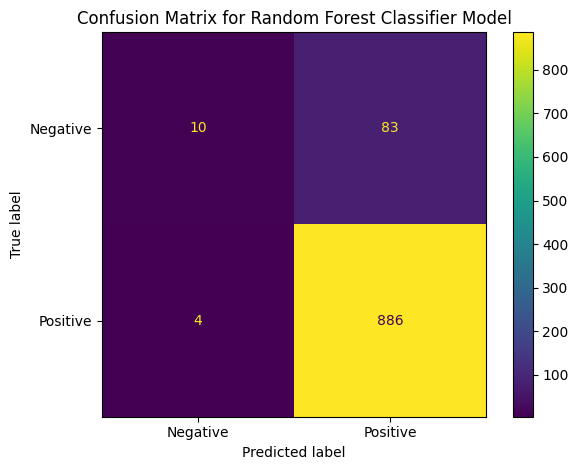

In [23]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, rf.predict(X_test))
print('---------------------- Confusion Matrix for Random Forest Classifier Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

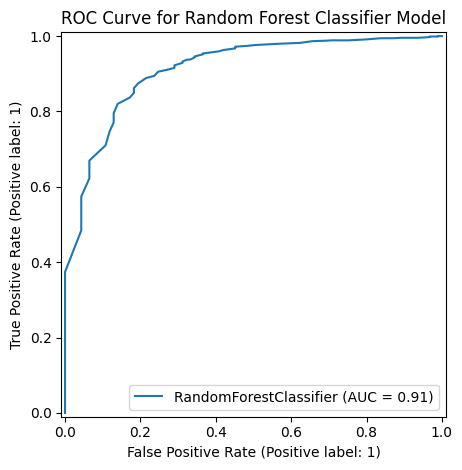

In [24]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf, X_test, y_test)

plt.title('ROC Curve for Random Forest Classifier Model')
plt.tight_layout()
plt.show()

In [25]:
# Classification report for Random Forest Classifier model
print('---------------------- Classification Report of Random Forest Classifier Model ----------------------')
print(classification_report(y_test, rf.predict(X_test), target_names=['Negative', 'Positive']))

---------------------- Classification Report of Random Forest Classifier Model ----------------------
              precision    recall  f1-score   support

    Negative       0.71      0.11      0.19        93
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.81      0.55      0.57       983
weighted avg       0.90      0.91      0.88       983



In [26]:
# Initialize Linear Support Vector Classifier model
svc = LinearSVC()

# Train and evaluate the model
svc_accuracy, svc_precision, svc_recall, svc_f1, svc_auc_roc = train_evaluate_model(svc, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Linear Support Vector Classifier Model')
print('--------------------------------------')
print('Accuracy:', svc_accuracy)
print('Precision:', svc_precision)
print('Recall:', svc_recall)
print('F1 Score:', svc_f1)
print('AUC-ROC:', svc_auc_roc)

Linear Support Vector Classifier Model
--------------------------------------
Accuracy: 0.9257375381485249
Precision: 0.9493949394939494
Recall: 0.9696629213483146
F1 Score: 0.9594219010561423
AUC-ROC: 0.737519632717168


---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------


<Figure size 800x600 with 0 Axes>

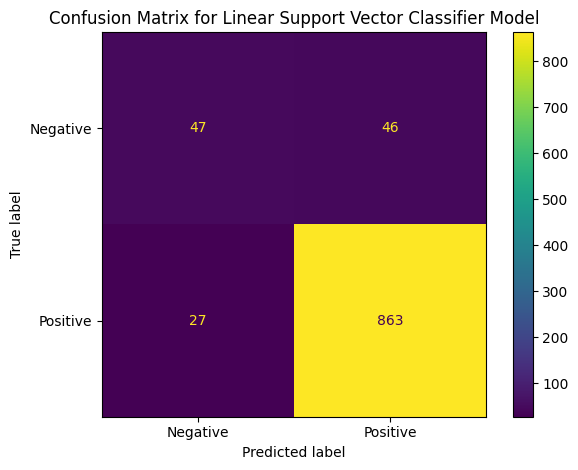

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
print('---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

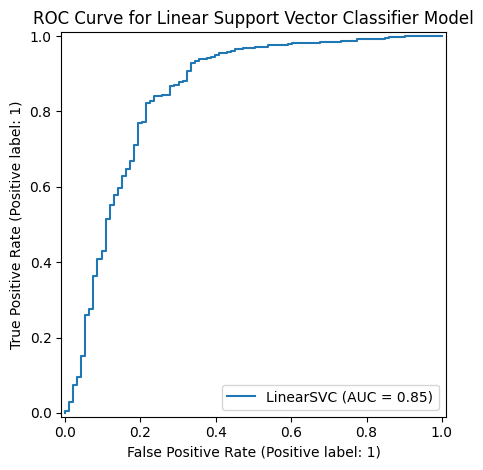

In [28]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(svc, X_test, y_test)

plt.title('ROC Curve for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.show()

In [29]:
# Classification report for Linear Support Vector Classifier model
print('---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------')
print(classification_report(y_test, svc.predict(X_test), target_names=['Negative', 'Positive']))

---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------
              precision    recall  f1-score   support

    Negative       0.64      0.51      0.56        93
    Positive       0.95      0.97      0.96       890

    accuracy                           0.93       983
   macro avg       0.79      0.74      0.76       983
weighted avg       0.92      0.93      0.92       983



In [30]:
# Importing the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the vocabulary size
vocab_size = 5000
max_len = 100

# Define the embedding dimension
embedding_dim = 32

# Define the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(32, return_sequences=True),
    Dropout(0.5),
    LSTM(16, return_sequences=False),  # Set return_sequences to False for the last LSTM layer
    Dropout(0.5),
    Dense(1, activation='relu')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model by providing an input shape
model.build(input_shape=(None, max_len))

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,473 (669.82 KB)

 Trainable params: 171,473 (669.82 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
history = model.fit(X_train, y_train, epochs=10,
                    batch_size=64, validation_data=(X_test,
                                                    y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', accuracy)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step - accuracy: 0.4685 - loss: 1.7575 - val_accuracy: 0.9054 - val_loss: 0.3800
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.7949 - loss: 0.6866 - val_accuracy: 0.9054 - val_loss: 0.3479
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.6120 - loss: 0.9214 - val_accuracy: 0.0946 - val_loss: 0.8016
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.6351 - loss: 0.8126 - val_accuracy: 0.9054 - val_loss: 1.5083
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.8590 - loss: 1.1530 - val_accuracy: 0.9054 - val_loss: 0.3261
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - accuracy: 0.8183 - loss: 0.7261 - val_accuracy: 0.9054 - val_loss: 0.3210
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.7683 - loss: 0.6947 - val_accuracy: 0.9054 - val_loss: 0.4285
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - accuracy: 0.8072 - loss: 0.7159 - val_accu

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        93
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.45      0.50      0.48       983
weighted avg       0.82      0.91      0.86       983

------------------------------------------------------------


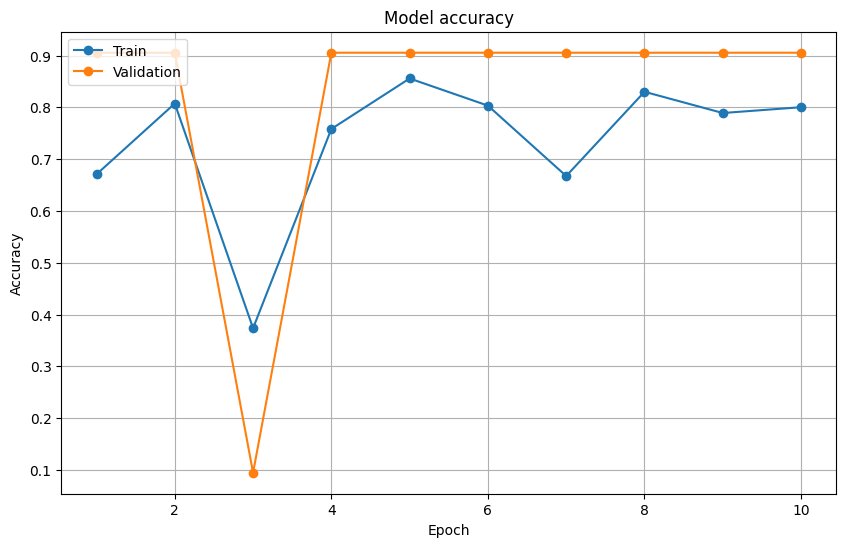

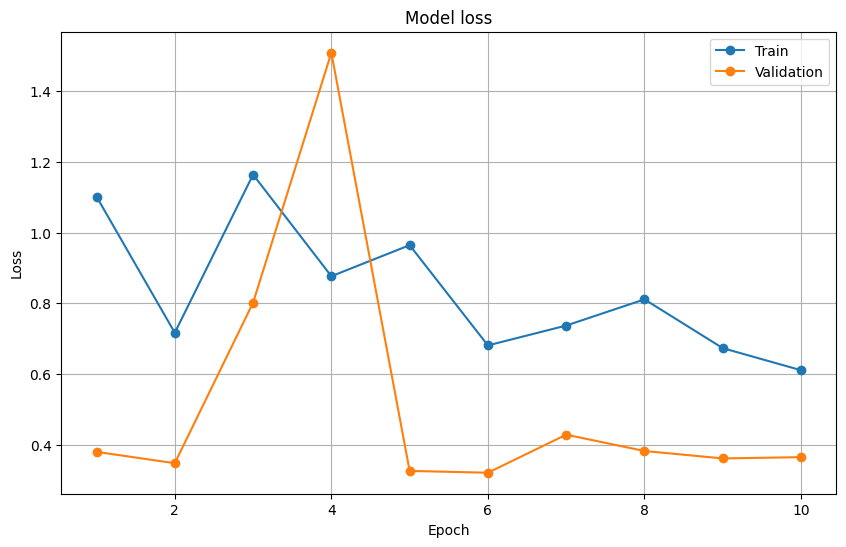

In [32]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

# Plot training history with parallel lines
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['accuracy'], marker='o')
plt.plot(epochs, history.history['val_accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dropout, Dense

# Define the GRU model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    GRU(32, return_sequences=True),
    Dropout(0.5),
    GRU(16, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model by providing an input shape
gru_model.build(input_shape=(None, max_len))

# Print the model summary
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 32)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 32)             │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 16)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,753 (659.19 KB)

 Trainable params: 168,753 (659.19 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)
print('GRU Model Accuracy:', gru_accuracy)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 29s 239ms/step - accuracy: 0.8712 - loss: 0.4667 - val_accuracy: 0.9059 - val_loss: 0.3124
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.9071 - loss: 0.3317 - val_accuracy: 0.9059 - val_loss: 0.3134
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.8955 - loss: 0.3615 - val_accuracy: 0.9059 - val_loss: 0.3121
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.9056 - loss: 0.3365 - val_accuracy: 0.9059 - val_loss: 0.3121
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.9042 - loss: 0.3396 - val_accuracy: 0.9059 - val_loss: 0.3121
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - accuracy: 0.9040 - loss: 0.3341 - val_accuracy: 0.9059 - val_loss: 0.3122
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.8999 - loss: 0.3377 - val_accuracy: 0.9059 - val_loss: 0.3121
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - accuracy: 0.9062 - loss: 0

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        93
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.45      0.50      0.48       983
weighted avg       0.82      0.91      0.86       983

------------------------------------------------------------


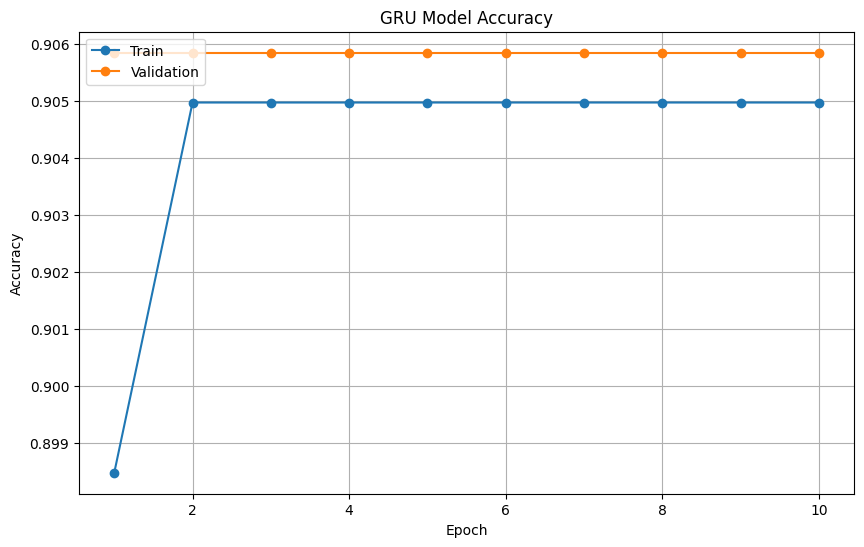

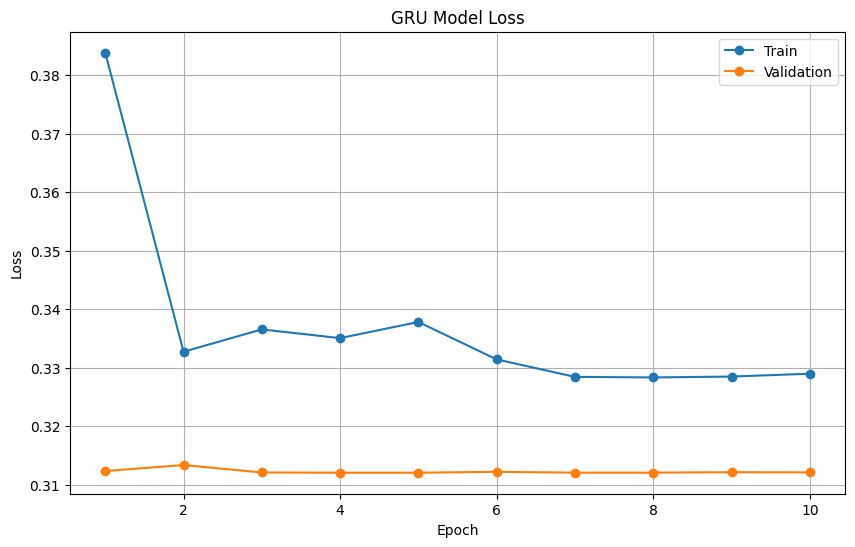

In [35]:
# Make predictions
gru_y_pred = gru_model.predict(X_test)
gru_y_pred = (gru_y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, gru_y_pred, target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')
# Plot training history
epochs = range(1, len(gru_history.history['accuracy']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, gru_history.history['accuracy'], marker='o')
plt.plot(epochs, gru_history.history['val_accuracy'], marker='o')
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, gru_history.history['loss'], marker='o')
plt.plot(epochs, gru_history.history['val_loss'], marker='o')
plt.title('GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [36]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from keras.models import Model

# Define your attention-based RNN model structure
attention_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(32, return_sequences=True),
    # ... your attention mechanism here that outputs (None, max_len, features) ...
    GlobalAveragePooling1D(),  # Aggregates the sequence output to shape (None, features)
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
attention_model.build(input_shape=(None, max_len))
attention_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 32)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,353 (657.63 KB)

 Trainable params: 168,353 (657.63 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train the model
attention_history = attention_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
attention_loss, attention_accuracy = attention_model.evaluate(X_test, y_test)
print('Attention-based RNN Model Accuracy:', attention_accuracy)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.8959 - loss: 0.3563 - val_accuracy: 0.9059 - val_loss: 0.3120
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9037 - loss: 0.3279 - val_accuracy: 0.9059 - val_loss: 0.3131
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9026 - loss: 0.3294 - val_accuracy: 0.9059 - val_loss: 0.3119
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9015 - loss: 0.3301 - val_accuracy: 0.9059 - val_loss: 0.3124
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9112 - loss: 0.3082 - val_accuracy: 0.9059 - val_loss: 0.3119
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9005 - loss: 0.3349 - val_accuracy: 0.9059 - val_loss: 0.3117
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9129 - loss: 0.3029 - val_accuracy: 0.9059 - val_loss: 0.3113
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.9204 - loss: 0

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        93
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.45      0.50      0.48       983
weighted avg       0.82      0.91      0.86       983

------------------------------------------------------------


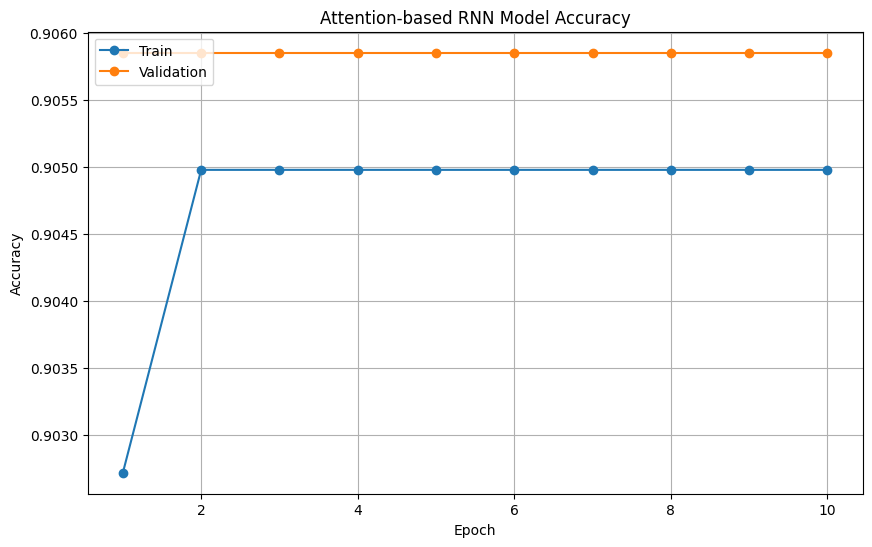

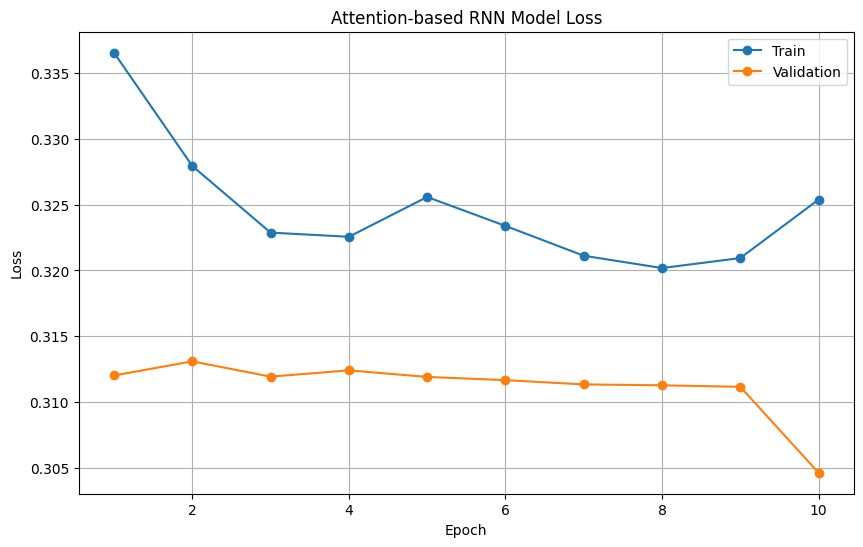

In [38]:
# Make predictions
attention_y_pred = attention_model.predict(X_test)
attention_y_pred = (attention_y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, attention_y_pred, target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')
# Plot training history
epochs = range(1, len(attention_history.history['accuracy']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, attention_history.history['accuracy'], marker='o')
plt.plot(epochs, attention_history.history['val_accuracy'], marker='o')
plt.title('Attention-based RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, attention_history.history['loss'], marker='o')
plt.plot(epochs, attention_history.history['val_loss'], marker='o')
plt.title('Attention-based RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Define the CNN model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model by providing an input shape
cnn_model.build(input_shape=(None, max_len))

# Print the model summary
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 32)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,909 (710.58 KB)

 Trainable params: 181,909 (710.58 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the model
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print('CNN Model Accuracy:', cnn_accuracy)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8093 - loss: 0.5696 - val_accuracy: 0.9059 - val_loss: 0.3938
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9071 - loss: 0.4872 - val_accuracy: 0.9059 - val_loss: 0.3831
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9010 - loss: 0.4814 - val_accuracy: 0.9059 - val_loss: 0.3487
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9059 - loss: 0.4368 - val_accuracy: 0.9059 - val_loss: 0.3352
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9057 - loss: 0.4407 - val_accuracy: 0.9059 - val_loss: 0.3431
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9084 - loss: 0.4115 - val_accuracy: 0.9059 - val_loss: 0.3108
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9079 - loss: 0.3992 - val_accuracy: 0.9059 - val_loss: 0.3036
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9116 - loss: 0.3843 - val_acc

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        93
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.45      0.50      0.48       983
weighted avg       0.82      0.91      0.86       983

------------------------------------------------------------


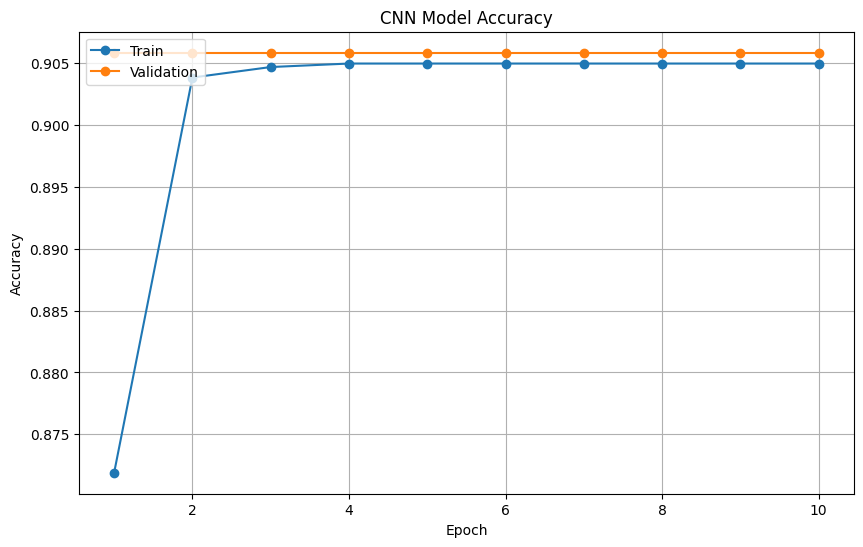

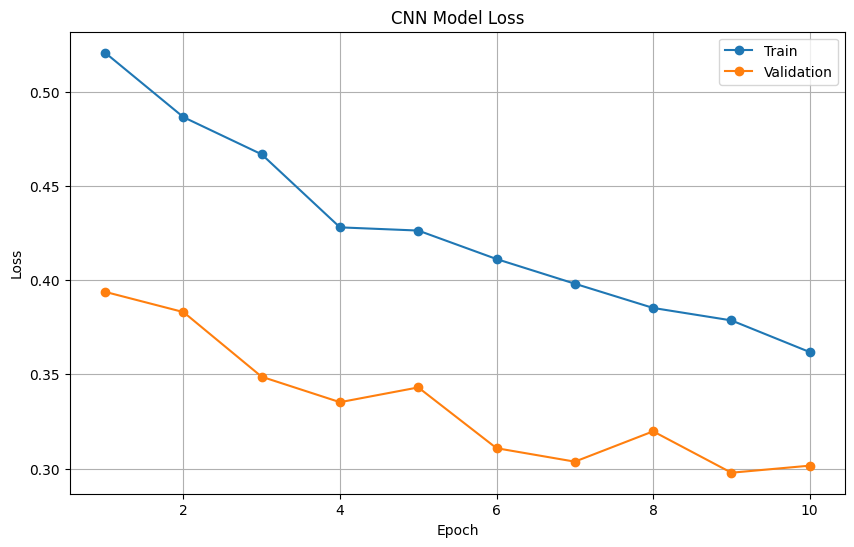

In [41]:
# Make predictions
cnn_y_pred = cnn_model.predict(X_test)
cnn_y_pred = (cnn_y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, cnn_y_pred, target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

# Plot training history
epochs = range(1, len(cnn_history.history['accuracy']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, cnn_history.history['accuracy'], marker='o')
plt.plot(epochs, cnn_history.history['val_accuracy'], marker='o')
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, cnn_history.history['loss'], marker='o')
plt.plot(epochs, cnn_history.history['val_loss'], marker='o')
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()